# polynomial feature (concatenate in 1st dimension)

## Package Installation

In [1]:
import os
import sys

# Path

In [2]:
print(os.getcwd())

C:\Users\Administrator\Desktop\12\Experiment_1_10trails


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

## Libraries

In [4]:

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle

## Data preparation

In [5]:
data = pickle.load(open(training_data_kok14_galfa, 'rb'))
# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

## Split train, validation and testing set from X_train and Y_train.

In [6]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

In [7]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

x_train= (23268, 414) , y_train= (23268, 2)
x_val= (7756, 414) , y_val= (7756, 2)
x_test= (7757, 414) , y_test= (7757, 2)


## Plot a few training samples

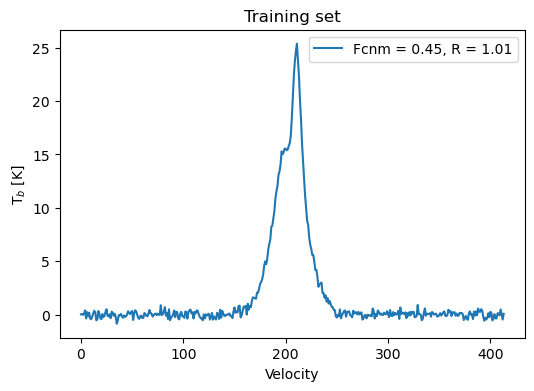

In [8]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[0, :], label=f'Fcnm = {round(Y_train[20000,0], 2)}, R = {round(Y_train[0,1], 2)}')

plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

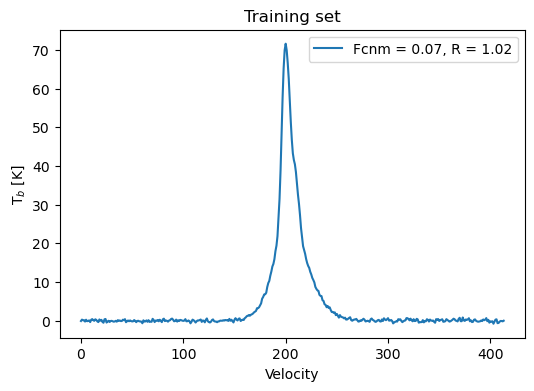

In [9]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[1000, :], label=f'Fcnm = {round(Y_train[10000,0], 2)}, R = {round(Y_train[10000,1], 2)}')

plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('T$_b$ [K]')
plt.legend()
plt.show()

## Data loader

In [10]:
# data loader 
class HI_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        
        self.x = x
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.y[:,0])
    
    def __getitem__(self, idx):
        
        #zero = np.linspace(0, 1.0, 414).reshape(1, -1)
        spectra = self.x[idx,:]
        two =  spectra**2
        result = np.vstack((spectra, two))
        #print(result)
        label = self.y[idx,:]
        if self.transform:
            result = self.transform(result)
            #print(result.shape)
            result = result.reshape(1, result.shape[0], result.shape[1])
        if self.target_transform:
            label = self.target_transform(label)
        return result, label

In [11]:
# transform to tenor 
class ToTensor_x():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [12]:
# transform to tenor 
class ToTensor_y():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [13]:
# initialize dataset
dataset_train = HI_dataset(x_train, y_train,transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_val = HI_dataset(x_val, y_val,transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_test = HI_dataset(x_test, y_test,transform=ToTensor_x(), target_transform=ToTensor_y())

In [14]:
# initialize data loader
batch_size = 20 
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle =True)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_val, batch_size = batch_size, shuffle =False)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle =False)

In [15]:
# test data loader
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 1, 2, 414])
torch.Size([20, 2])


## CNN Model

In [27]:
import math
class Net_origin_deep(nn.Module):
    def __init__(self, num_output=2, in_channels=1, num_output_1=72, num_output_2=64, num_output_3=56, num_output_4=48):
        super(Net_origin_deep, self).__init__()
        # layers
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels=num_output_1, 
                                kernel_size=(2,6), stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn1 = nn.BatchNorm2d(num_output_1)
        
        self.conv2 = nn.Conv2d(in_channels= num_output_1, out_channels=num_output_2, 
                                kernel_size=(1,40), stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn2 = nn.BatchNorm2d(num_output_2)
        
            
        self.conv3 = nn.Conv2d(in_channels = num_output_2, out_channels=num_output_3, 
                               kernel_size=(1,6), stride=1, padding=0, bias=True, padding_mode='zeros')
        
        
        self.bn3 = nn.BatchNorm2d(num_output_3)
        
        self.conv4 = nn.Conv2d(in_channels= num_output_3, out_channels=num_output_4,
                               kernel_size=(1,40), stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn4 = nn.BatchNorm2d(num_output_4)
        
        self.conv5 = nn.Conv2d(in_channels = num_output_4, out_channels=40, kernel_size=(1,6),
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn5 = nn.BatchNorm2d(40)
        
        self.conv6 = nn.Conv2d(in_channels= 40, out_channels=32, kernel_size=(1,40), 
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn6 = nn.BatchNorm2d(32)
        
        self.conv7 = nn.Conv2d(in_channels = 32, out_channels=16, kernel_size=(1,6), 
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn7 = nn.BatchNorm2d(16)
        
        self.conv8 = nn.Conv2d(in_channels= 16, out_channels=8, kernel_size=(1,40), 
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn8 = nn.BatchNorm2d(8)
        
        self.dropout0 = nn.Dropout(0.20)
        self.dropout = nn.Dropout(0.30)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(1904, num_output)
        #self.linear2 = nn.Linear(3808, 1)
        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        
        #block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #rint(2, x.size())
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        # concatenate 3 
        ##x = self.dropout0(x)
        #print(3, x.size())
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        #
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        ##x = self.dropout0(x)
        #
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        #
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        ##x = self.dropout0(x)
        #
        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)
        #
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)
        #
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x

## Model Training and Evaluation 

In [28]:
# train 
def train(epoch):
    model.train()
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward
        outputs = model(inputs)
        loss = loss_function(outputs, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
    print("total loss=",train_loss)
    return train_loss/total

In [29]:
def validation(epoch):
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    # Save checkpoint.
    error =  test_loss / total
    print(f"validation MSE in epoch {epoch}= ", error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/polynomial_e_s2.pth')
        best_err = error
    return error

In [30]:
def test(epoch):
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        #print(f'Test performance in epoch {epoch}: avg_error = {test_loss/total}')
        return test_loss/total

## Start 10 trail Training

In [31]:
# define number of trails, number of epoch and learning rate
num_trial = 10
num_epoch = 80
learning_rate = 0.005
# the savier of best validation performance and coresponding testing performance.
vali = []
testing = []
# saver for each trials
train_trails = []
validate_trails =[]
test_trails = []

In [32]:
def trail(num_epoch):
    global vali
    global testing
    global scheduler
    global model
    global lr
    #define savor
    global train_trails
    global validate_trails
    global test_trails
    for epoch in range(num_epoch):
        train_err = train(epoch)
        vali_err = validation(epoch)
        scheduler.step()
        test_err = test(epoch)
        # save data
        train_trails.append(train_err)
        validate_trails.append(vali_err)
        test_trails.append(test_err)
    # final test
    validation_error,test_error = validate_model()
    print("test err=",test_error)
    vali.append(validation_error)
    testing.append(test_error)

In [33]:
def validate_model():
    global model
    model = Net_origin_deep()
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    checkpoint = torch.load('./checkpoint/polynomial_e_s2.pth',
                            map_location=torch.device('cuda:0'))
    model.load_state_dict(checkpoint['net'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    validation_error = validation(epoch)
    test_error = test(epoch)
    return validation_error, test_error

In [34]:
# start 10 trails.
for i in range (0, num_trial):
    print(f'start the {i}th trial:')
    # model initialization
    lr=learning_rate
    model = Net_origin_deep()
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    optimizer = torch.optim.SGD(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                     milestones = [65], 
                                                     gamma=0.1, last_epoch=-1, 
                                                     verbose=False)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    trail(num_epoch)

start the 0th trial:
total loss= 754.3666604310274
validation MSE in epoch 0=  0.009750960988884522
best_err: 0.009750960988884522 Saving..
total loss= 379.0614056587219
validation MSE in epoch 1=  0.008177478628003967
best_err: 0.008177478628003967 Saving..
total loss= 306.39846473746
validation MSE in epoch 2=  0.008113114521291171
best_err: 0.008113114521291171 Saving..
total loss= 269.53331510256976
validation MSE in epoch 3=  0.008219765643927818
total loss= 245.98198055569082
validation MSE in epoch 4=  0.007966595614276626
best_err: 0.007966595614276626 Saving..
total loss= 233.19880027556792
validation MSE in epoch 5=  0.008566842788360656
total loss= 218.25284607429057
validation MSE in epoch 6=  0.009008483957051856
total loss= 207.79097898723558
validation MSE in epoch 7=  0.11501995364853429
total loss= 193.59087582444772
validation MSE in epoch 8=  0.008996316383265212
total loss= 182.15476416237652
validation MSE in epoch 9=  0.010267868970863977
total loss= 177.077216699

# plot traing process

## plot the training and validation and testing chart

In [35]:
def plott(x, ti):
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

In [36]:
def plott_20(x, ti):
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index+59: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails(last 20 epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()

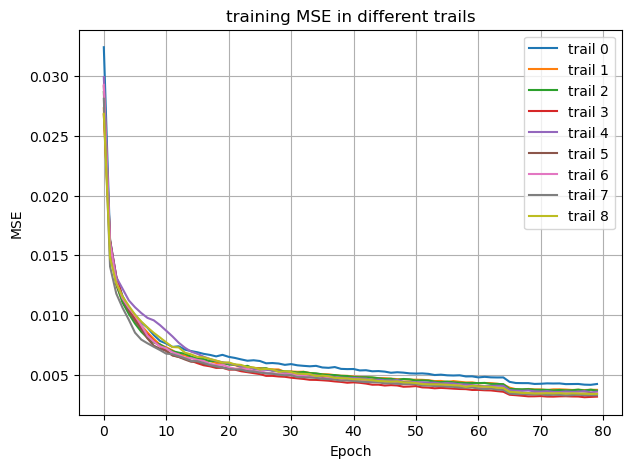

In [37]:
# training 
x = np.array(train_trails)
plott(x, "training")

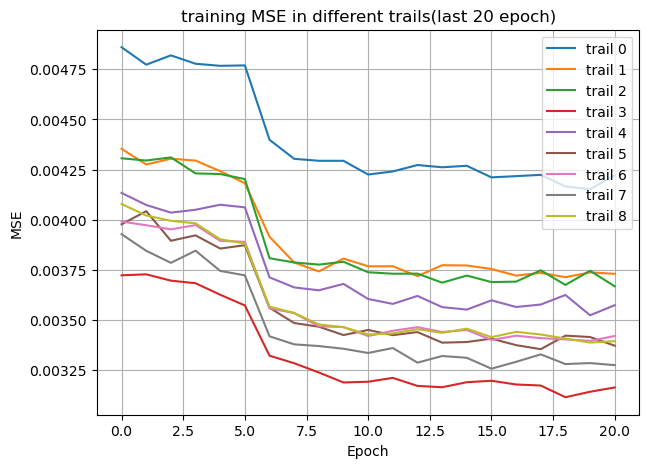

In [38]:
# training 
x = np.array(train_trails)
plott_20(x, "training")

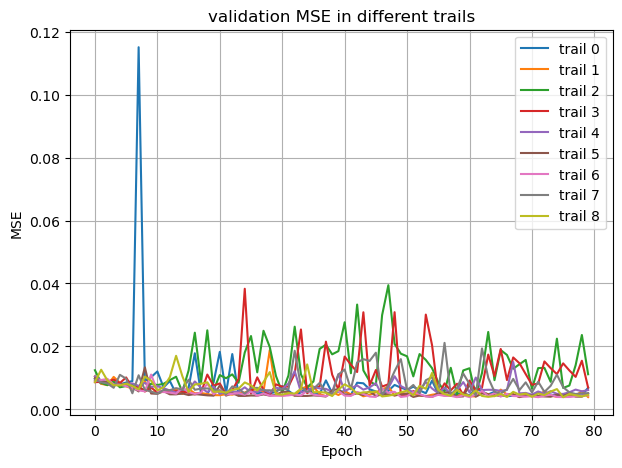

In [39]:
# validation
x = np.array(validate_trails)
plott(x, "validation")

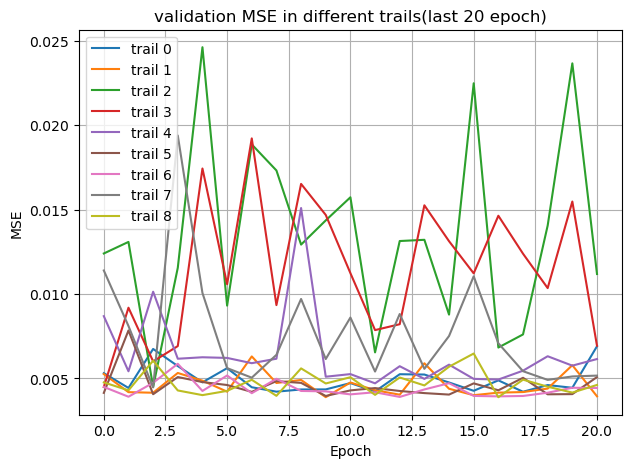

In [40]:
# validation
x = np.array(validate_trails)
plott_20(x, "validation")

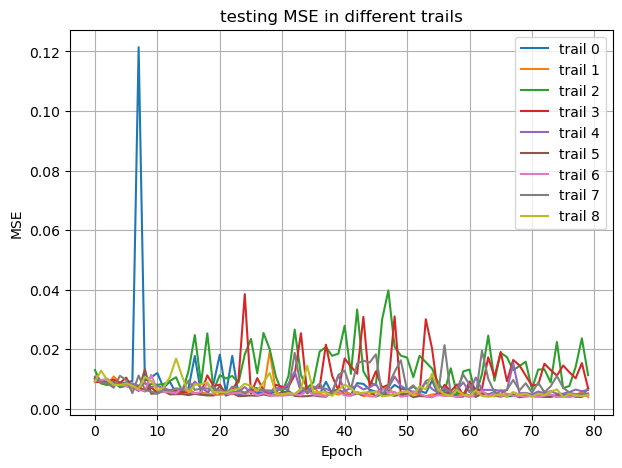

In [41]:
# testing 
x = np.array(test_trails)
plott(x, "testing")

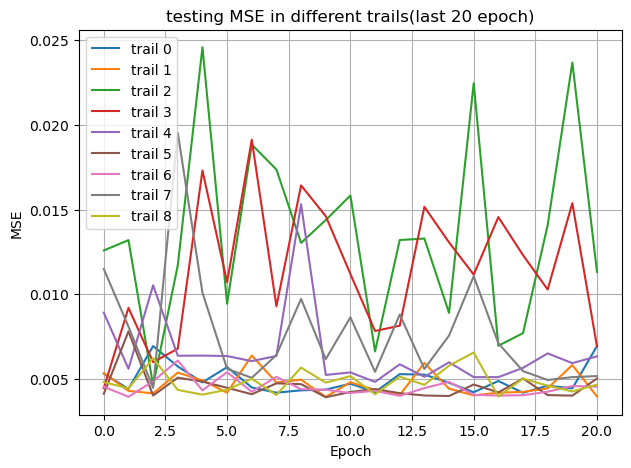

In [42]:
# testng
x =  np.array(test_trails)
plott_20(x, "testing")

## plot the best velidation MSE and testing MSE

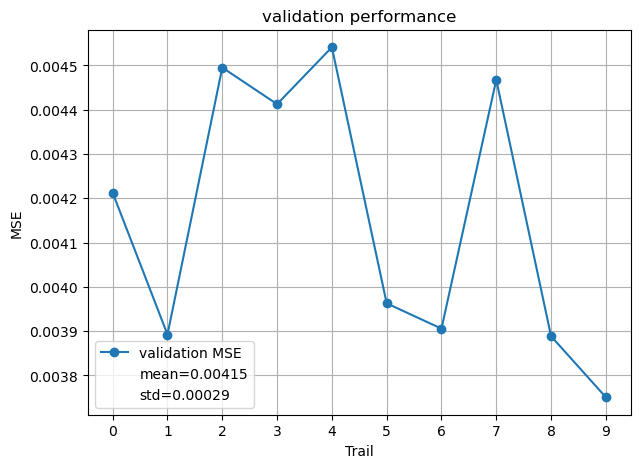

validation mean= 0.004152976139792306
validation std= 0.00028886571577116355


In [43]:
x = vali
plt.figure(figsize=(7,5))
plt.title('validation performance')
plt.plot(x, label='validation MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),5)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),5)}")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("validation mean=",np.mean(x))
print("validation std=",np.std(x))

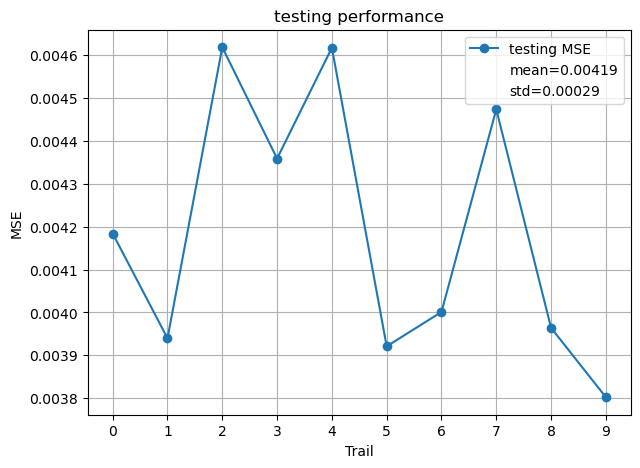

testing mean= 0.004187880600838919
testing std= 0.0002909050238829065


In [44]:
x = testing
plt.figure(figsize=(7,5))
plt.title('testing performance')
plt.plot(x, label='testing MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),5)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),5)}")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("testing mean=",np.mean(x))
print("testing std=",np.std(x))

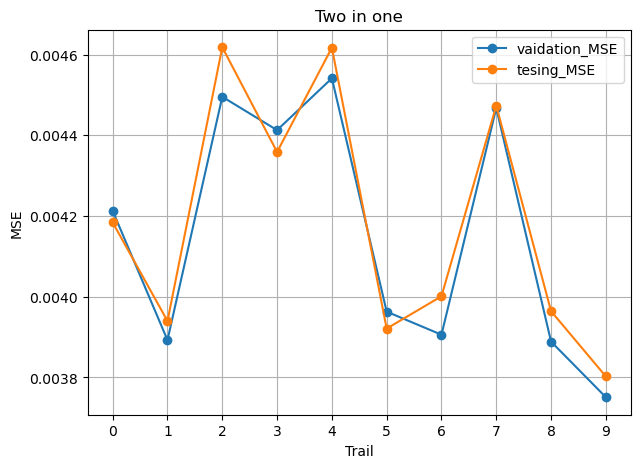

In [45]:
x1 = vali
x2 = testing
plt.figure(figsize=(7,5))
plt.title('Two in one')
plt.plot(x1, label='vaidation_MSE',marker='o')
plt.plot(x2, label='tesing_MSE',marker='o')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()

## Save CSV

In [46]:
x1 = np.array(vali).reshape(1, -1)
x2 = np.array(testing).reshape(1, -1)
two = np.vstack((x1,x2))
df = pd.DataFrame(two).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\polynomial_1_s2.csv")

In [47]:
# save data 
x1 = np.array(train_trails).reshape(1, -1)
x2 = np.array(validate_trails).reshape(1, -1)
x3 = np.array(test_trails).reshape(1, -1)
three = np.vstack((x1,x2,x3))
df = pd.DataFrame(three).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\polynomial_1_whole_s2.csv")